**THIS IS NOT FINANCIAL ADVICE. DO YOUR OWN RESEARCH. USE AT YOUR OWN RISK.**

In [1]:
# For more information on this notebook, see my blog posts:
# https://medium.com/wwblog/technical-analysis-of-investment-prices-with-python-fe44fcdbceea
# https://medium.com/wwblog/using-papermill-to-auto-generate-technical-analyses-for-investments-19900e518f9e
# https://medium.com/wwblog/create-a-stochastic-oscillator-in-python-a7da42473677

import pandas as pd
import pandas_ta as ta
import yfinance as yf
import requests_cache
import matplotlib.pyplot as plt
import mplfinance as mpf

from IPython.display import display, Markdown, Latex
from matplotlib.lines import Line2D

# In the blog post, I included the various prep and plot functions directly in the notebook itself.
# But I'm moved these to external scripts to avoid cluttering up the technical analysis with a bunch of code.
%run "../ta/prepare_df.py"
%run "../ta/plot_df.py"

In [2]:
# Parameters
ticker_symbol = "MSFT"

In [3]:
# Parameters
ticker_symbol = "TSLA"


In [4]:
session = requests_cache.CachedSession("yfinance.cache")
session.headers["User-Agent"] = f"ta-{ticker_symbol}-notebook/1.0"
ticker = yf.Ticker(ticker_symbol, session=session)
ticker_short_name = ticker.info["shortName"]
display(Markdown(f"# Technical analysis: {ticker_short_name} ({ticker_symbol}), {today_str}"))

# Technical analysis: Tesla, Inc. (TSLA), 2022-01-30

## 1 Load data

In [5]:
# Use unadjusted close prices, since we want to plot capital gains
# (i.e. exclude cash flow yields like dividends).
hist = ticker.history(start=date_ranges["2Y"], end=today_str, auto_adjust=False, back_adjust=False)
hist.head()

,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
Date,,,,,,,,
2020-01-31,128.000000,130.600006,126.503998,130.113998,130.113998,78596500,0,0.0
2020-02-03,134.738007,157.227997,134.703995,156.000000,156.000000,235325000,0,0.0
2020-02-04,176.591995,193.798004,166.776001,177.412003,177.412003,304694000,0,0.0
2020-02-05,164.651993,169.195999,140.822006,146.940002,146.940002,242119000,0,0.0
2020-02-06,139.983994,159.166000,137.399994,149.792007,149.792007,199404000,0,0.0


## 2 Candlestick charts

See [Candlestick definition](https://www.investopedia.com/terms/c/candlestick.asp) for more information.

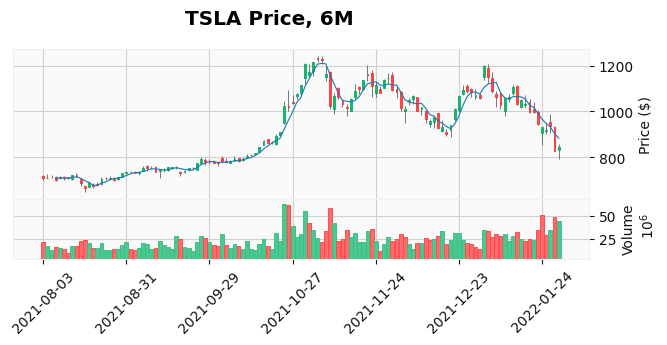

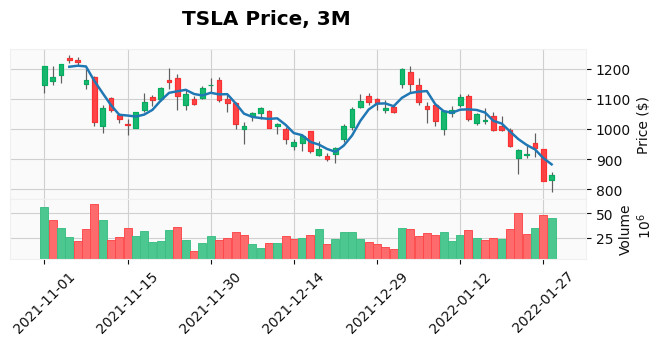

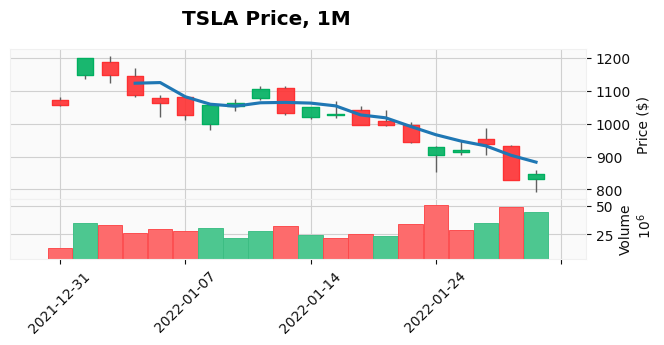

In [6]:
for rng in ["6M", "3M", "1M"]:
    plot_candlestick(hist, ticker_symbol, rng)

## 3 Capital appreciation

See [Capital Appreciation](https://www.investopedia.com/terms/c/capitalappreciation.asp) for more information.

Capital appreciation (i.e., capital gains) do not include cash flow yields (e.g., dividends, bond coupons, mutual fund capital gains distributions).

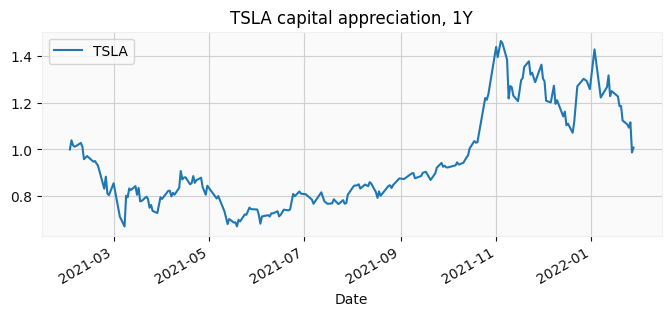

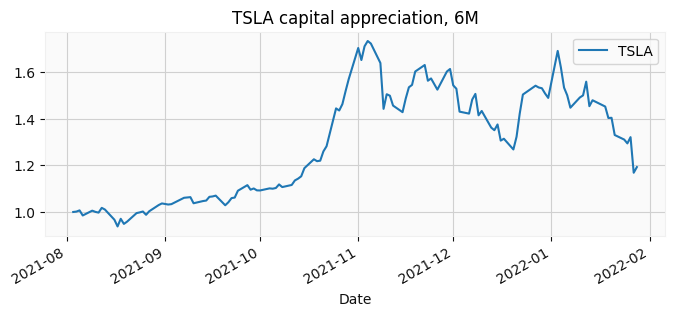

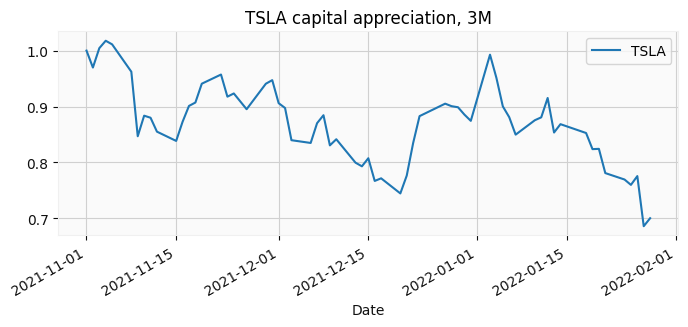

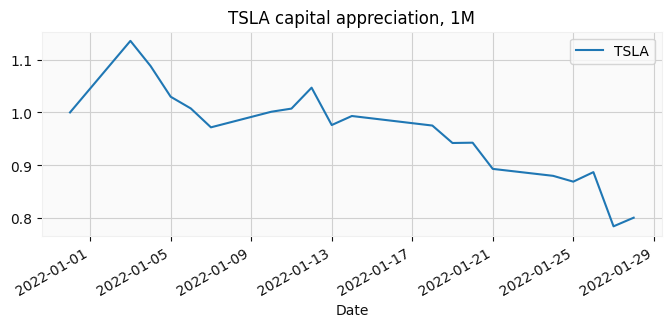

In [7]:
for rng in ["1Y", "6M", "3M", "1M"]:
    plot_capital_appreciation(hist, ticker_symbol, rng)

## 4 Trend indicators

See:

- [Trend Trading](https://www.investopedia.com/terms/t/trendtrading.asp)

### 4.1 Simple Moving Average Crossover

See [How to Use a Moving Average to Buy Stocks](https://www.investopedia.com/articles/active-trading/052014/how-use-moving-average-buy-stocks.asp).

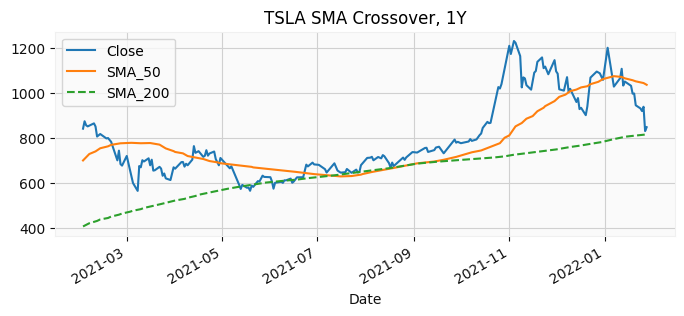

In [8]:
df = add_sma_crossover(hist)
plot_sma_crossover(df, ticker_symbol, "1Y")

## 5 Volatility indicators

### 5.1 Bollinger Bands

See [Bollinger Band](https://www.investopedia.com/terms/b/bollingerbands.asp) for more information.

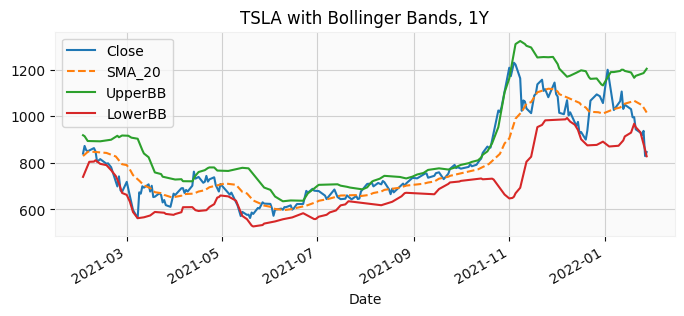

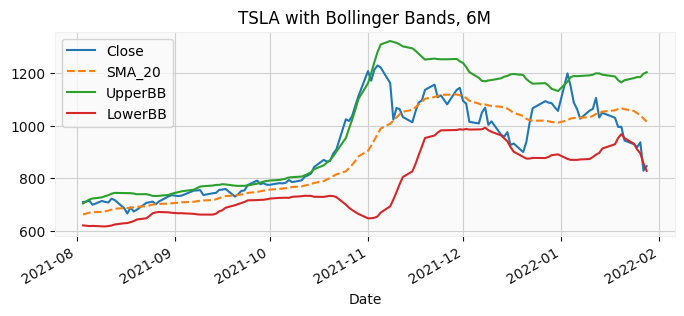

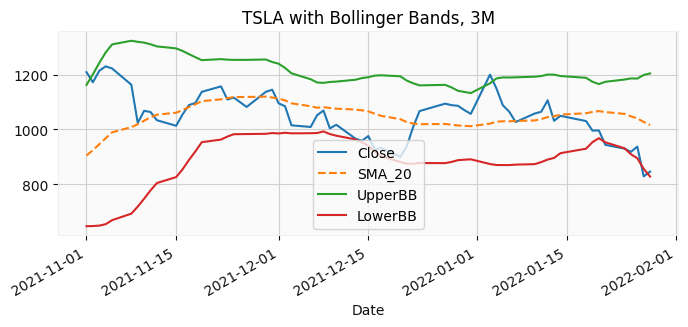

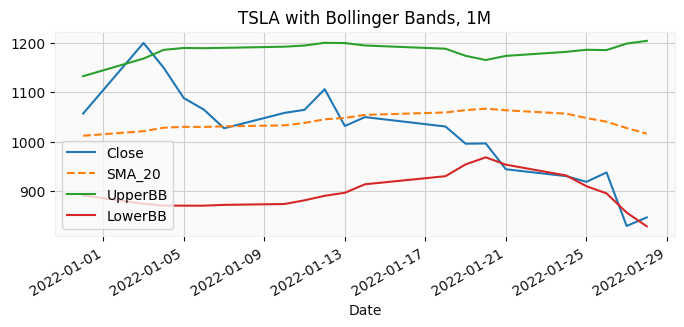

In [9]:
df = add_bollinger_bands(hist)
for rng in ["1Y", "6M", "3M", "1M"]:
    plot_bollinger(df, ticker_symbol, rng)

## 6 Momentum indicators

See [Momentum indicators](https://www.investopedia.com/investing/momentum-and-relative-strength-index/) for more information.

### 6.1 Stochastic Oscillator

See [Stochastic Oscillator](https://www.investopedia.com/terms/s/stochasticoscillator.asp) for more information.

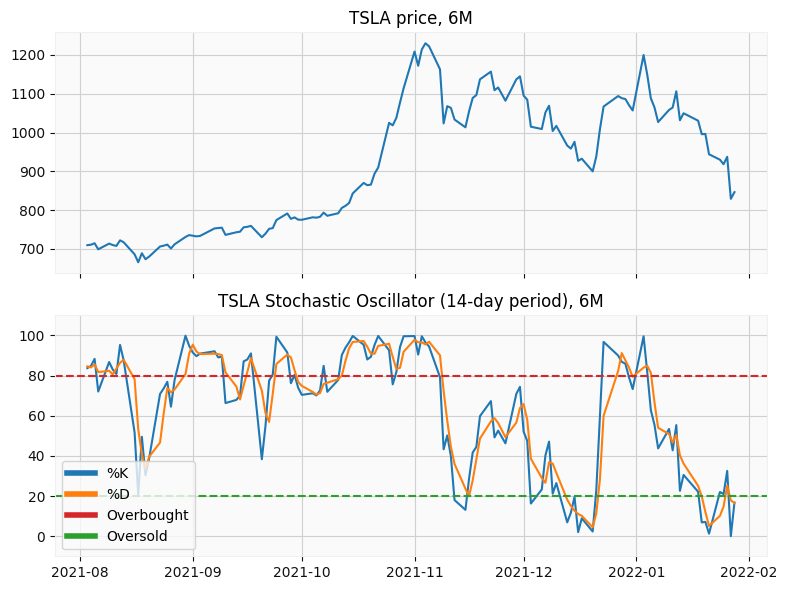

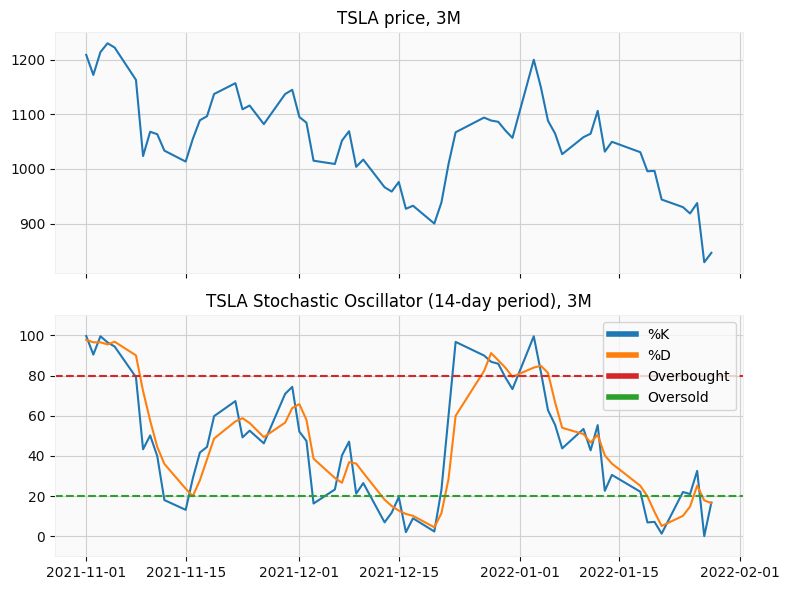

In [10]:
df = add_stochastic_oscillator(hist)
for rng in ["6M", "3M"]:
    plot_stochastic_oscillator(df, ticker_symbol, rng)

### 6.2 Relative Strength Index (RSI)

See [Relative Strength Index (RSI)](https://www.investopedia.com/terms/r/rsi.asp) for more information.

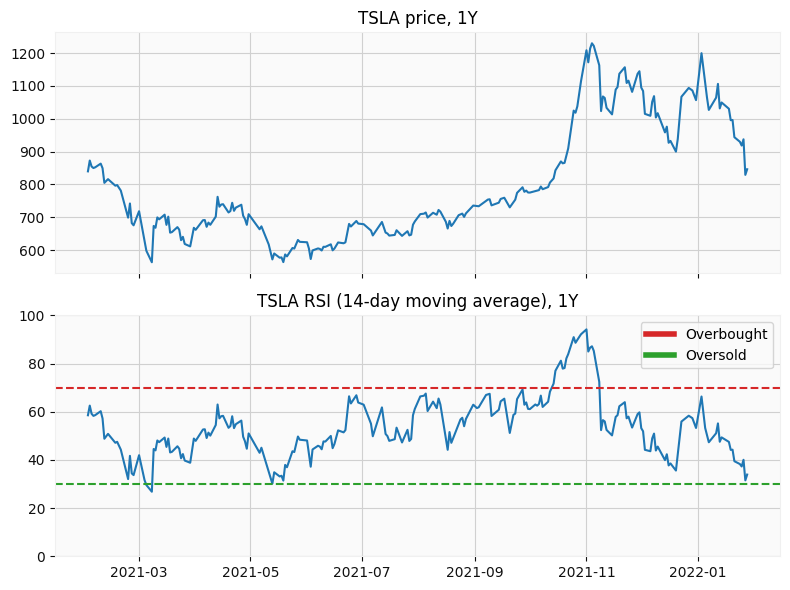

In [11]:
df = add_rsi(hist)
plot_rsi(df, ticker_symbol, "1Y")

### 6.3 Moving Average Convergence Divergence (MACD)

See:

- [Moving Average Convergence Divergence (MACD)](https://www.investopedia.com/terms/m/macd.asp)
- [What Is the Moving Average Convergence Divergence, and How Is It Calculated?](https://www.investopedia.com/ask/answers/122414/what-moving-average-convergence-divergence-macd-formula-and-how-it-calculated.asp)
- [MACD: A Primer](https://www.investopedia.com/trading/macd/)


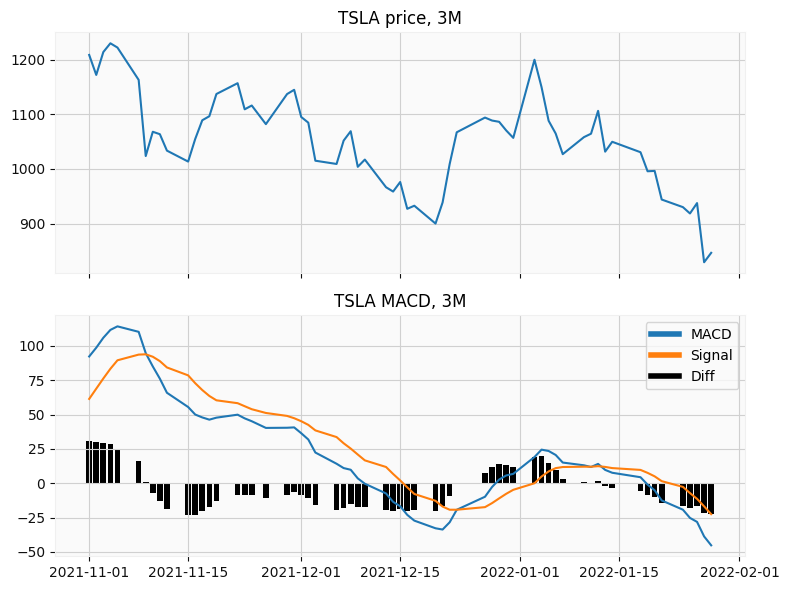

In [12]:
df = add_macd(hist)
plot_macd(df, ticker_symbol, "3M")

### 6.4 On-Balance Volume (OBV)

See [On-Balance Volume (OBV) Definition](https://www.investopedia.com/terms/o/onbalancevolume.asp).

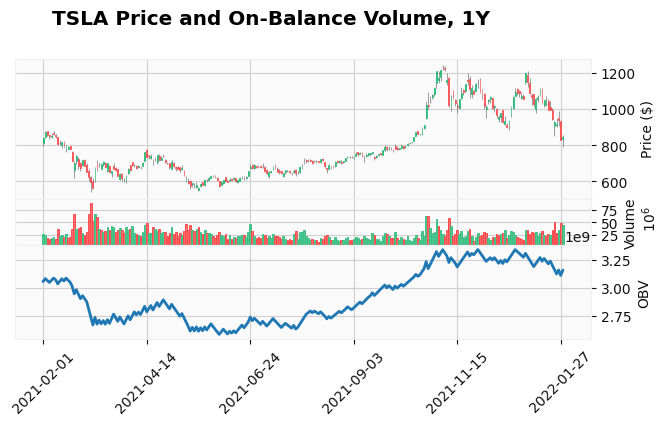

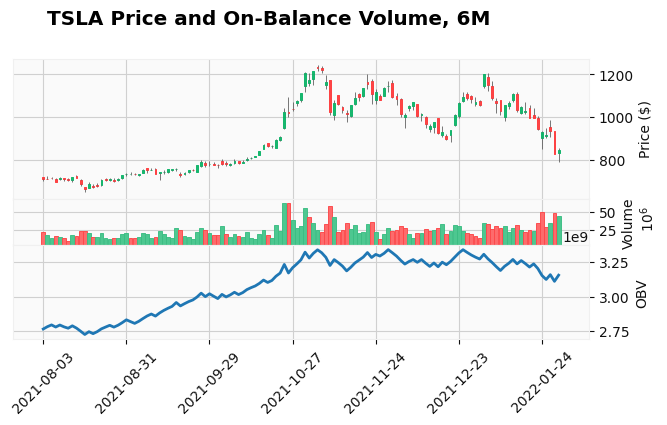

In [13]:
df = add_obv(hist)
for rng in ["1Y", "6M"]:
    plot_obv(df, ticker_symbol, rng)